<a href="https://colab.research.google.com/github/JanMikicki/albedo-prediction/blob/main/moon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jan Mikicki - Task 1 for "Machine Learning Model for the Planetary Albedo" project

---

The problem involved predicting the Moon's albedo data from it's chemical composition maps. In other words, given a set of surface scans for various elements (iron, potassium, etc.) we should try and predict the albedo view.
This way, hopefully some useful relationship between the two will be formed, which would enable to make predictions about planetary/lunar surfaces given only chemical scans, or vice-versa.
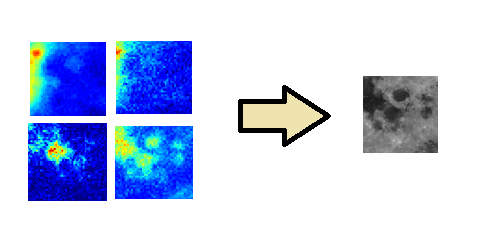

Task description specified that the ML model should be trained on a left side of the Moon and then make a prediction on the right/untrainded portion.

I decided to use a Pix2Pix architecture ([paper](https://arxiv.org/abs/1611.07004)), which specializes in image-to-image translation tasks.

In [ ]:
! git clone https://github.com/ML4SCI/ML4SCI_GSoC.git

Cloning into 'ML4SCI_GSoC'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 75 (delta 21), reused 46 (delta 13), pack-reused 0
Unpacking objects: 100% (75/75), done.
Checking out files: 100% (36/36), done.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Original images:


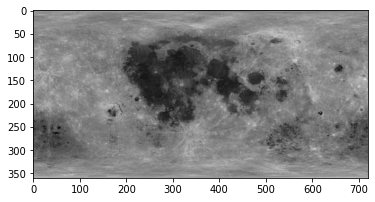

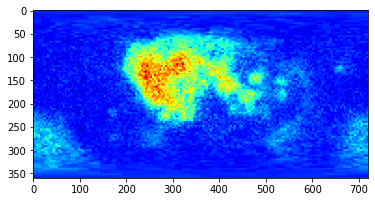

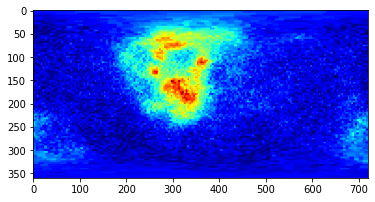

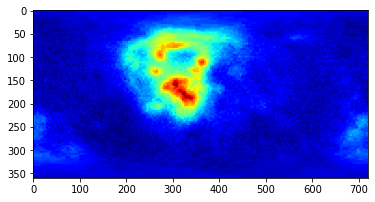

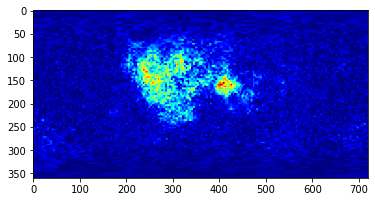

In [ ]:
albedo_data = np.genfromtxt('/content/ML4SCI_GSoC/Messenger/Moon/Albedo_Map.csv', delimiter=',')
fe_data = np.genfromtxt('/content/ML4SCI_GSoC/Messenger/Moon/LPFe_Map.csv', delimiter=',')
k_data = np.genfromtxt('/content/ML4SCI_GSoC/Messenger/Moon/LPK_Map.csv', delimiter=',')
th_data = np.genfromtxt('/content/ML4SCI_GSoC/Messenger/Moon/LPTh_Map.csv', delimiter=',')
ti_data = np.genfromtxt('/content/ML4SCI_GSoC/Messenger/Moon/LPTi_Map.csv', delimiter=',')

data_arr = [albedo_data, fe_data, k_data, th_data, ti_data]
data_arr = [a / a.max() for a in data_arr]

%matplotlib inline

print("Original images:")
for i in range(5):
    plt.figure()
    if i == 0:
        plt.imshow(data_arr[i], cmap='gray')
    else:
        plt.imshow(data_arr[i], cmap='jet')

In [ ]:
print([x.shape for x in data_arr])
print([x.max() for x in data_arr])
print([x.min() for x in data_arr])

[(360, 720), (360, 720), (360, 720), (360, 720), (360, 720)]
[1.0, 1.0, 1.0, 1.0, 1.0]
[0.1912853363866077, 0.0, 0.0, 0.0003145826176571625, 0.0]


In [ ]:
import torch

! pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

The idea was to create a dataset which would sample randomly from the left half of our maps and ocasionally apply some transforms like random rotation or vertical/horizontal flip. This way out training dataset could be virtually increased -- relatively small training area was one of the biggest problems in both exercises.

In [ ]:
crop_transform = A.Compose(
    [A.RandomCrop(width=128, height=128),
     A.Resize(width=256, height=256),
     A.HorizontalFlip(p=0.5),
     A.VerticalFlip(p=0.5),
     A.RandomRotate90(p=0.5),
     ], 
     additional_targets={"image0": "image", "image1": "image", "image2": "image", "image3": "image"},
)

torch.Size([1, 4, 256, 256])
torch.Size([1, 1, 256, 256])


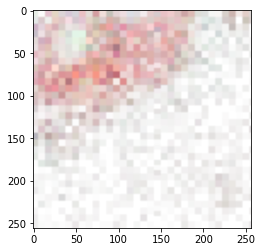

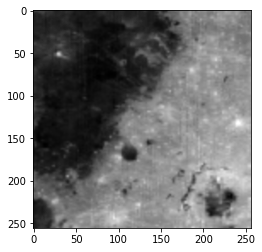

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image

class MapDataset(Dataset):
    def __init__(self, half):
        if half == "left":
            self.target = data_arr[0][:, :360]
            self.a = data_arr[1][:, :360]
            self.b = data_arr[2][:, :360]
            self.c = data_arr[3][:, :360]
            self.d = data_arr[4][:, :360]
        elif half == 'right':
            self.target = data_arr[0][:, 360:]
            self.a = data_arr[1][:, 360:]
            self.b = data_arr[2][:, 360:]
            self.c = data_arr[3][:, 360:]
            self.d = data_arr[4][:, 360:]

    def __len__(self):
        #return len(self.list_files)
        return 100 # virtual dataset size

    def __getitem__(self, index):

        augmentations = crop_transform(image=self.target, image0=self.a, 
                                       image1=self.b, image2=self.c, 
                                       image3=self.d)

        target_image = augmentations["image"]

        a = augmentations["image0"]
        b = augmentations["image1"]
        c = augmentations["image2"]
        d = augmentations["image3"]

        # combine all chemical pictures into (4, h, w) input array
        input_image = np.dstack((a, b, c, d)).transpose(2, 0, 1)

        #return input_image, target_image
        return torch.from_numpy(input_image), torch.from_numpy(target_image).unsqueeze(0)

dataset = MapDataset(half="left")
loader = DataLoader(dataset, batch_size=1)

for x, y in loader:
    plt.figure()
    print(x.size())
    print(y.size())
    plt.imshow(x[0].transpose(2, 0), cmap='jet')  # this is torch transpose here
                                                  # h, w, c are for imshow
                                                  # c, h, w for pytorch
    plt.figure()
    plt.imshow(y[0][0], cmap='gray')
    break


Above one can see a single input and output training sample returned by the dataset. Input in this case is an image/tensor composed of all four chemical elements information (concateneted along the channel dimension) and output is the corresponding albedo section.
Input doesn't really make sense visually, because it has four channels.

Below a Generative Adversarial Network discriminator is constructed. It's task is to judge whether some albedo sample is real or generated by our model. It outputs a 30x30 array where each value says whether a particular, corresponding section of the image was deemed fake of real.

In [ ]:
import torch.nn as nn

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            #nn.BatchNorm2d(out_channels),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                5,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x

In [ ]:
def test_discriminator():
    x = torch.randn((1, 4, 256, 256))
    y = torch.randn((1, 1, 256, 256))
    model = Discriminator(in_channels=4)
    preds = model(x, y)
    #print(model)
    print(preds.shape)

test_discriminator()

torch.Size([1, 1, 30, 30])


The generator for our model produces an albedo image given chemical images as an input. It's only goal is to convince the discriminator that a generated sample was real. This way it slowly learns to produce more and more realistic looking images.

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(out_channels),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=4, out_channels=1, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, out_channels, kernel_size=4, stride=2, padding=1),
            #nn.Tanh(),
            nn.Sigmoid(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

In [ ]:
def test_generator():
    x = torch.randn((1, 4, 256, 256))
    model = Generator(in_channels=4, out_channels=1, features=64)
    preds = model(x)
    print(preds.shape)

test_generator()

torch.Size([1, 1, 256, 256])


In [ ]:
from torchvision.utils import save_image
# Some util functions

def save_some_examples(gen, val_loader, epoch, folder, device):
    x, y = next(iter(val_loader))
    x, y = x.to(device), y.to(device)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        save_image(y_fake, "/content/" + folder + f"/y_gen_{epoch}.png")
        save_image(y, "/content/" + folder + f"/y_real_{epoch}.png")
    gen.train()

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    #path  = os.path.join('/checkpoints/', filename)
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr, device):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


As with other GAN-type architectures, training takes shape of dicriminator learning to differentiane between real and generated images, whereas the generator learns to make a produced image more 'real' for the dicriminator.

In [ ]:
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Assigned device: ", device)

def train_fn(
    disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler=0, d_scaler=0,
):
    loop = tqdm(loader, position=0, leave=True)

    for idx, (x, y) in enumerate(loop):
        x = x.to(device)
        y = y.to(device)
        
        y_fake = gen(x)
        D_real = disc(x, y)
        D_real_loss = bce(D_real, torch.ones_like(D_real))
        D_fake = disc(x, y_fake.detach())
        D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
        D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        D_loss.backward()
        opt_disc.step()

        D_fake = disc(x, y_fake)
        G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
        L1 = l1_loss(y_fake, y) * 100
        G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        G_loss.backward()
        opt_gen.step()

        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )

Assigned device:  cuda


In [ ]:
def learn(gen_lr, disc_lr, batch_size, epochs, save=True, load=False, gen_path="", disc_path="",):
    # I don't know why but PyTorch insisted on double() input...  strange
    disc = Discriminator(in_channels=4).double().to(device)
    gen = Generator(in_channels=4, features=64).double().to(device)
    opt_disc = optim.Adam(disc.parameters(), lr=disc_lr, betas=(0.5, 0.999),)
    opt_gen = optim.Adam(gen.parameters(), lr=gen_lr, betas=(0.5, 0.999))
    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()

    if load:
        load_checkpoint(
            gen_path, gen, opt_gen, lr,
        )
        load_checkpoint(
            disc_path, disc, opt_disc, lr,
        )

    train_dataset = MapDataset(half="left")
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
    )

    val_dataset = MapDataset(half="right")
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    for epoch in range(epochs):
        train_fn(
            disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE,
        )

        if save and epoch % 50 == 0:
            save_checkpoint(gen, opt_gen, filename=f"gen_checkpoint_epoch_{epoch}")
            save_checkpoint(disc, opt_disc, filename=f"disc_checkpoint_epoch_{epoch}")

        if epoch % 10 == 0:
            save_some_examples(gen, val_loader, epoch, folder="evaluation", device=device)
    
    save_checkpoint(gen, opt_gen, filename=f"gen_checkpoint_final")
    save_checkpoint(disc, opt_disc, filename=f"disc_checkpoint_final")

In [ ]:
import shutil
import os

if os.path.exists('/content/evaluation'):
    shutil.rmtree('/content/evaluation')
if os.path.exists('/content/checkpoints'):
    shutil.rmtree('/content/checkpoints')

In [ ]:
# !mkdir evaluation
# !mkdir checkpoints

# learn(gen_lr=0.0001, disc_lr=0.0004, batch_size=16, epochs=200)

Because I composed this notebook over a couple of days, I lost the training cell output. (It was a progress bar and loss values for the generator and the discriminator. One day I trained the model and saved the weights, another day I loaded the weights and made some further visualizations -- this resulted in previously saved cell outputs being deleted -- I can resend you the training cell output seperately if you want).

One thing woth noting here is the ratio between the generator and the discriminator learning rates. Generally, picking the learning weights for GANs is based on some good practices and rules of thumb. From my understanding though, not very mych work went into prooving the convergence parameters for such networks ([link](https://arxiv.org/abs/1706.08500)). 

The general consensus is to set the discriminator's learning rate lower that the generator's. That is because in each training loop the discriminator makes the prediction twice - once for real image and once for fake. Therefore its parameters update is also bigger in every iteration. Another factor is the fact that the discriminator model is usually a lot smaller then the generator's -- it has a simpler task (this also results in faster learning).

However, if the discriminator learns too slowly the generator takes advantege of that and can produce unrealistic looking images that still "fool" the discriminator. I had an instance where after a few dozen of epoch, big black, symmetrical dots started appearing on the surface of generated albedo maps.

Eventually I picked 0.0001 learning rate for the generator and a *higher* 0.0004 learning rate for discriminator. This solved the black dots problem but the generator/discriminator learning rate ratio is still one of the parameters which could signinficantly improve (or worsen) the results for all GAN based solutions fot this task.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# shutil.move("/content/gen_checkpoint_final", "/content/drive/MyDrive")
# shutil.move("/content/disc_checkpoint_final", "/content/drive/MyDrive")
# shutil.copy("/content/evaluation", "/content/drive/MyDrive") 

Mounted at /content/drive


In [ ]:
from skimage.transform import resize

gen = Generator(in_channels=4, features=64).double().to(device)
opt_gen = optim.Adam(gen.parameters(), lr=0.0001, betas=(0.5, 0.999))
load_checkpoint("/content/drive/MyDrive/gen_checkpoint_final", gen, opt_gen, lr=0.0001, device=device)

val_dataset = MapDataset(half="right")
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

entire_right_side = resize(data_arr[0][:, 360:], (256, 256))
entire_left_side = resize(data_arr[0][:, :360], (256, 256))
#entire_map = data_arr[0]

a = data_arr[1]
b = data_arr[2]
c = data_arr[3]
d = data_arr[4]

input_image = np.dstack((a, b, c, d))

right_chem = resize(input_image[:, 360:, :], (256, 256)).transpose(2, 0, 1)
left_chem = resize(input_image[:, :360, :], (256, 256)).transpose(2, 0, 1)

right_chem = torch.from_numpy(right_chem).unsqueeze(0)
left_chem_chem = torch.from_numpy(left_chem).unsqueeze(0)

gen.eval()

out_right = gen(right_chem.to(device))
out_right = out_right.cpu().detach().numpy()[0][0]

out_left = gen(left_chem_chem.to(device))
out_left = out_left.cpu().detach().numpy()[0][0]

=> Loading checkpoint


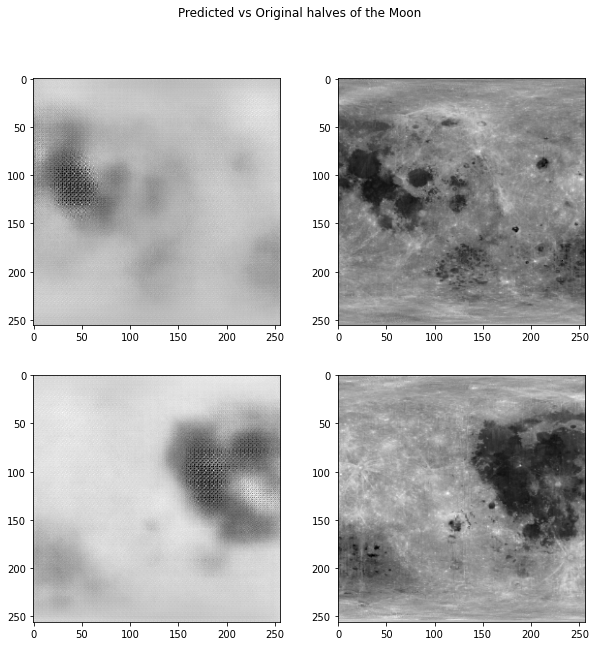

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle("Predicted vs Original halves of the Moon")
axs[0,0].imshow(out_right, cmap='gray')
axs[0,1].imshow(entire_right_side, cmap='gray')
axs[1,0].imshow(out_left, cmap='gray')
axs[1,1].imshow(entire_left_side, cmap='gray')
plt.show()

As one can see the generated albedo images (on the left) look simmilar to their real counterparts. Thay still lack detail and fidelity, but the general crater pattern as well as pixel brightness is not far off.

There is some grid-like pattern visible on the generated images. While they are common in GAN-generated pictures they should fade away with time. I suspect that the fact they didn't completely dissapear here is partially because the input images were originally at a lower resolution that the albedo data (example below: even though all provided images were the same in resolution, the original chemical data seems to have been at a lower one, originally). This might also be a reason why some detail was lost.

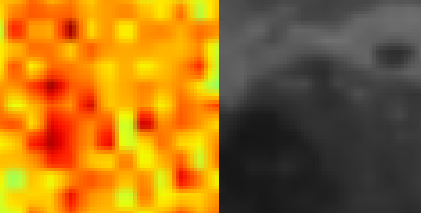

Below are some additional visualizations, like histogram comparison, absolute difference image and average pixel value difference. After comparing two entire halves of the Moon, some additional random samples are compared.

As one can see on the histograms, the model almost always predicted a bit too much of the median/light gray value. This is probably due to the fact that many small surface details, which make the real albedo histogram a bit more spread out, were lost.

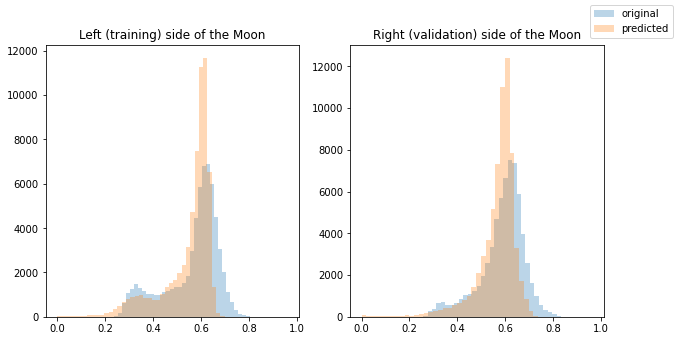

In [ ]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(10,5))

kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40)

axs[0].hist(entire_left_side.flatten(), label='original', **kwargs)
axs[0].hist(out_left.flatten(), label='predicted', **kwargs)
axs[0].set_title("Left (training) side of the Moon")

axs[1].hist(entire_right_side.flatten(), **kwargs)
axs[1].hist(out_right.flatten(), **kwargs)
axs[1].set_title("Right (validation) side of the Moon")

fig.legend()
plt.show()

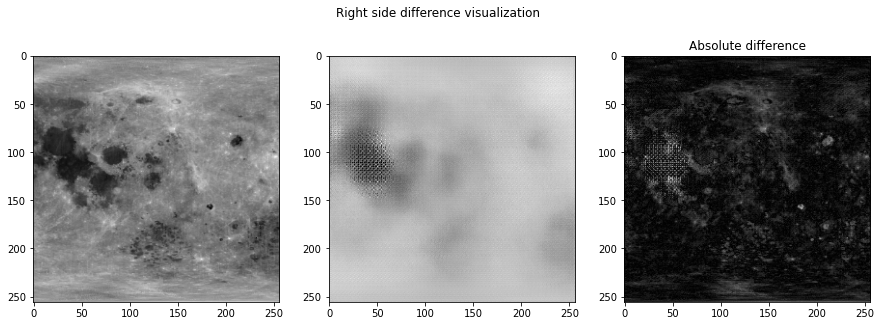

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle("Right side difference visualization")
axs[0].imshow(entire_right_side, cmap='gray')
axs[1].imshow(out_right, cmap='gray')
axs[2].imshow(np.abs(entire_right_side - out_right), cmap='gray')
axs[2].set_title("Absolute difference")
plt.show()

In [ ]:
print("Average difference per pixel: ", (np.sum(np.abs(entire_right_side - out_right)) + np.sum(np.abs(entire_left_side - out_left))) / (2 * 256 ** 2))

Average difference per pixel:  0.049220155583039896


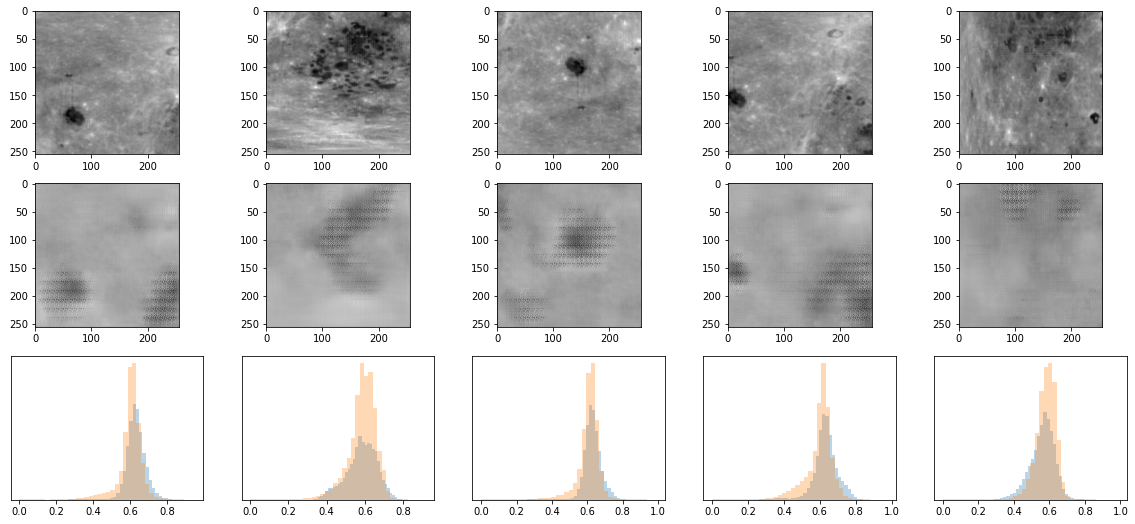

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(20, 9))

for i in range(5):
    x, y = next(iter(val_loader))
    x, y = x.to(device), y.to(device)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        axs[0, i].imshow(y.cpu()[0][0], cmap='gray')
        axs[1, i].imshow(y_fake.cpu().numpy()[0][0], cmap='gray')
        axs[2, i].hist(y.cpu()[0][0].flatten(), **kwargs)
        axs[2, i].hist(y_fake.cpu().numpy()[0][0].flatten(), **kwargs)
        axs[2, i].set_yticks([])

plt.show()
    

In conclusion, the model learned to predict the Moon's albedo data relatively well, while still leaving some room for improvement. The general pattern and crater placement seems good, but the futher work can be done to eliminate the grid-like pattern and adding more surface details.

One of the most influential parameters that could change future results, using this type of a model architecture, is a ratio between generator's and discriminator's learning rates.